<a href="https://colab.research.google.com/github/pompaFunebris/ContextBasedCompression/blob/main/LZ77.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**LZ77 algorithm**

> LZ77 is one of the classic context-based compression algorithms. It was  published in papers by Abraham Lempel and Jacob Ziv in 1977. This loseless algorithm serves as a foundation for several advanced algorithms like LZW, LZSS, LZMA, which are widely used in various formats including GIF, DEFLATE (ZIP), and PNG.

The LZ77 works by finding repeating patterns withing a sequence and replacing them with a pointer to the last location of the sequence.

 **How does the LZ77 algorithm work?**


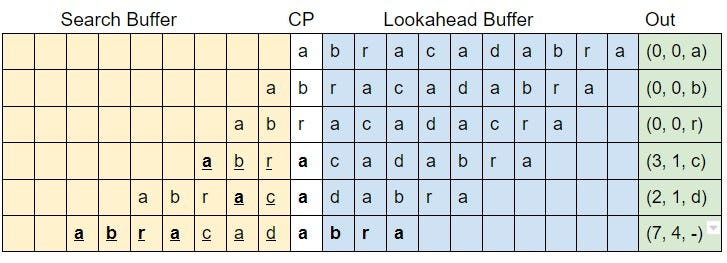                                          
                                        

Sources:
* https://www.youtube.com/watch?v=cSyK2iCqr4w

* https://towardsdatascience.com/how-data-compression-works-exploring-lz77-3a2c2e06c097
* https://miro.medium.com/v2/resize:fit:4800/format:webp/1*lAxi1TrfT8UNKj0KSUo6JA.jpeg  

In [ ]:
def find_longest_match(search_buffer, pattern):
    """
    Finds the longest match between the search buffer and the pattern.

    Args:
        search_buffer (list): The sequence in which we want to find the pattern.
        pattern (list): The pattern to search for.

    Returns:
        tuple: A tuple containing the longest match offset, longest match length, and the character after the match.

    Example:
        search_buffer = ['t', 'h', 'i', 's', 's']
        pattern = ['i', 's', ' ']
        longest_match_offset, longest_match_length, character_after = find_longest_match(search_buffer, pattern)

        longest_match_offset = 2 -> By how many positions pattern is left-shifted
        longest_match_length = 2 -> "is" is the longest match of length 2
        character_after = ' ' -> the first character that appears after matched sequence
    """
    longest_match_length = 0
    longest_match_offset = 0

    i = 0
    while i < len(search_buffer) - 1:
        match_length = 0

        # match_length < then len(pattern) - 1 because the last character has to be returnd by the function and later encoded
        while match_length < len(pattern) - 1 and i + match_length < len(search_buffer) and search_buffer[i + match_length] == pattern[match_length]:
            match_length += 1

        if match_length > longest_match_length:
            longest_match_length = match_length
            longest_match_offset = i

        # If a match is found, skip ahead to the end of the match
        if match_length > 0:
            i += match_length
        else:
            i += 1

    character_after = pattern[longest_match_length]
    longest_match_offset = len(search_buffer) - longest_match_offset

    return longest_match_offset, longest_match_length, character_after

In [ ]:
def lz77_encoder(input_sequence, ahead_buffer_bits=4, search_buffer_bits=10):
    """
    Encodes the input sequence using the LZ77 compression algorithm.

    Args:
        input_sequence (list): The input sequence to encode.
        ahead_buffer_bits (int): The number of bits to represent the size of the ahead buffer.
        search_buffer_bits (int): The number of bits to represent the size of the search buffer.

    Returns:
        list: The encoded sequence represented as a list of triples [offset, length, symbol].
    """
    # Generate the ASCII dictionary. We will encode single characters in ASCII when they are seen for the first time in the text
    encoder_dictionary = {}
    for i in range(2 ** 8):
        char = chr(i)
        encoder_dictionary[char] = i

    window_size = 12
    ahead_buffer_len = 2 ** ahead_buffer_bits
    delimiter_index = 2 ** search_buffer_bits

    # Initialize the sequence with some nulls and then append the input_sequence
    sequence = [None for _ in range(delimiter_index)]
    sequence.extend(input_sequence)

    encoded_sequence = []
    i = 0
    while i < len(input_sequence):

        # Sliding window consisting of two parts: search_buffer and pattern
        search_buffer = sequence[i:i + delimiter_index]
        pattern = sequence[i + delimiter_index:i + delimiter_index + ahead_buffer_len]

        # Get the longest match between pattern and search_buffer. Offset information will be important in the decoding phase
        longest_match_offset, longest_match_length, character_after = find_longest_match(search_buffer, pattern)
        encoded_sequence.append([longest_match_offset, longest_match_length, encoder_dictionary[character_after]])

        # If we matched a sequence, we have to move the window by more than one position
        i += longest_match_length + 1
    return encoded_sequence


In [ ]:
def lz77_decoder(input_sequence, ahead_buffer_bits=4, search_buffer_bits=10):
    """
    Decodes the input sequence using the LZ77 compression algorithm.

    Args:
        input_sequence (list): The encoded sequence represented as a list of triples [offset, length, symbol].
        ahead_buffer_bits (int): The number of bits used to represent the size of the ahead buffer.
        search_buffer_bits (int): The number of bits used to represent the size of the search buffer.

    Returns:
        str: The decoded sequence as a string.
    """
    decoded_sequence = ""
    for triple in input_sequence:
        longest_match_offset, longest_match_length, ascii_code = triple

        if longest_match_length == 0:
            # If the character does not appear in the search_buffer, then
            # we have to encode it with pure ascii and add it to the decoded_sequence
            letter = chr(ascii_code)
            decoded_sequence += letter
        else:
            # If there was a match, we know that we have to look in the already decoded sequence
            # We use the offset and match_length to navigate to the repated sequence.
            repeated_sequence = decoded_sequence[-longest_match_offset:-longest_match_offset + longest_match_length]
            decoded_sequence = decoded_sequence + repeated_sequence + chr(ascii_code)
    return decoded_sequence

Let's test whether the encoder and decoder are working ;))

In [ ]:
lorem_ipsum = """
  Lorem Ipsum is simply dummy text of the printing and typesetting industry.
  Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took
  a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries,
  but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s
  with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with
  desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.
  Contrary to popular belief, Lorem Ipsum is not simply random text. It has roots in a piece of classical Latin literature from
  45 BC, making it over 2000 years old. Richard McClintock, a Latin professor at Hampden-Sydney College in Virginia,
  looked up one of the more obscure Latin words, consectetur, from a Lorem Ipsum passage, and going through the cites
  of the word in classical literature, discovered the undoubtable source. Lorem Ipsum comes from sections 1.10.32 and
  1.10.33 of "de Finibus Bonorum et Malorum" (The Extremes of Good and Evil) by Cicero, written in 45 BC. This book is a
  treatise on the theory of ethics, very popular during the Renaissance. The first line of Lorem Ipsum, "Lorem ipsum dolor
  sit amet..", comes from a line in section 1.10.32.
"""

encoded_sequence = lz77_encoder(lorem_ipsum)
print(encoded_sequence)

In [ ]:
lz77_decoder(encoded_sequence)

In [ ]:
import requests
import zipfile
import textwrap


# Download the book
url = 'https://www.gutenberg.org/files/1342/1342-0.txt'
response = requests.get(url)
text = response.text

# Clean the text (remove special characters)
cleaned_text = ''.join(c for c in text if c.isprintable())

# Encode and decode the text
encoded_sequence = lz77_encoder(cleaned_text)
decoded_sequence = lz77_decoder(encoded_sequence)

# Print the results
print("Original Text:")
print(text[:1000])

print("\nEncoded Sequence:")
print(encoded_sequence[:50])

print("\nDecoded Text:")
# Breaks the text into lines so its not a single long string of text
wrapped_sequence = textwrap.fill(decoded_sequence[:1000], width=100)

print(wrapped_sequence)

In [ ]:
print("\nEncoded Sequence:")
print(encoded_sequence[-50:])

print("\nDecoded Text:")
print(decoded_sequence[:1000])